<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# Exam: <font color="#C70039">Data set and task description</font> Team 5
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/lehre.html">Gernot Heisenberg</a>
* Students:
    * Shah
    * Joost-Henning Groot Bramel, 11089617
* Date:   24.06.2025

In [1]:
# Imports

import pandas as pd
from sktime.datasets import load_from_tsfile_to_dataframe, load_tsf_to_dataframe
from pathlib import Path

from utils.data_loader import convert_tsf_to_dataframe

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose, STL

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np

In [2]:
columns = ["Dataset", "Benchmark", "Timestamp", "Result"]
results = pd.DataFrame(columns=columns)
results.head()

,Dataset,Benchmark,Timestamp,Result


# 0. Define common functions

In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Australian Electricity Demand (australian_electricity_demand_dataset.tsf)
This dataset contains 5 time series representing the half hourly electricity demand of 5 states in Australia: Victoria, New South Wales, Queensland, Tasmania and South Australia. It was extracted from R tsibbledata package.



## Load data
Download Link on sciebo: https://th-koeln.sciebo.de/s/Dutn70IIcdcdFmG

In [4]:
# Load Data
path = Path("data/exam/australian_electricity_demand_dataset.tsf").absolute()
df = convert_tsf_to_dataframe(path, replace_missing_vals_with="NaN")[0]
# df = pd.DataFrame(df,)
print(type(df))
display(df)

<class 'pandas.core.frame.DataFrame'>


,series_name,state,start_timestamp,series_value
0,T1,NSW,2002-01-01,"[5714.045004, 5360.189078, 5014.835118, 4602.7..."
1,T2,VIC,2002-01-01,"[3535.867064, 3383.499028, 3655.527552, 3510.4..."
2,T3,QUN,2002-01-01,"[3382.041342, 3288.315794, 3172.329022, 3020.3..."
3,T4,SA,2002-01-01,"[1191.078014, 1219.589472, 1119.173498, 1016.4..."
4,T5,TAS,2002-01-01,"[315.915504, 306.245864, 305.762576, 295.60219..."


In [5]:
df["series_length"] = df["series_value"].apply(len)
display(df)
min_length = df["series_length"].min()
print(f"Minimum length: {min_length}")
print(f"Length in days: {min_length/48}")
print(f"Length in years: {min_length/48/365}")

,series_name,state,start_timestamp,series_value,series_length
0,T1,NSW,2002-01-01,"[5714.045004, 5360.189078, 5014.835118, 4602.7...",230736
1,T2,VIC,2002-01-01,"[3535.867064, 3383.499028, 3655.527552, 3510.4...",230736
2,T3,QUN,2002-01-01,"[3382.041342, 3288.315794, 3172.329022, 3020.3...",232272
3,T4,SA,2002-01-01,"[1191.078014, 1219.589472, 1119.173498, 1016.4...",230784
4,T5,TAS,2002-01-01,"[315.915504, 306.245864, 305.762576, 295.60219...",230736


Minimum length: 230736
Length in days: 4807.0
Length in years: 13.169863013698631


In [6]:
# Assuming you have a start date and 30-minute intervals
start_date = '2002-01-01 00:00:00'  # Replace with your actual start date
freq = '30T'  # 30 minutes

# Create datetime index
datetime_index = pd.date_range(start=start_date, periods=df["series_length"].max(), freq=freq)

all_rows =  []

for columns, row in df.iterrows():
    series_name = row["series_name"]
    state = row["state"]

    i = 0
    for value in row["series_value"]:
        all_rows.append({
            "series_name": series_name,
            "state": state,
            "timestamp": datetime_index[i],
            "data": value,
        })
        i += 1



C:\Users\Joost\AppData\Local\Temp\ipykernel_14372\2686994883.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, periods=df["series_length"].max(), freq=freq)


In [7]:
df_exploded = pd.DataFrame(all_rows)
display(df_exploded)

,series_name,state,timestamp,data
0,T1,NSW,2002-01-01 00:00:00,5714.045004
1,T1,NSW,2002-01-01 00:30:00,5360.189078
2,T1,NSW,2002-01-01 01:00:00,5014.835118
3,T1,NSW,2002-01-01 01:30:00,4602.755516
4,T1,NSW,2002-01-01 02:00:00,4285.179828
...,...,...,...,...
1155259,T5,TAS,2015-02-28 21:30:00,360.118254
1155260,T5,TAS,2015-02-28 22:00:00,344.564576
1155261,T5,TAS,2015-02-28 22:30:00,324.242366
1155262,T5,TAS,2015-02-28 23:00:00,305.643636


## Baseline(s) Australian Electricity

### Findings
- Datasets of the States have different length => Missing values?
- Tasmania has a big negative outlier around 60.000 tiks (maybe a Blackout or renewable over production and grid compansation)

### Questions
- Normalize demand between diffent states?
- Is smoothing or subsampeling senseable


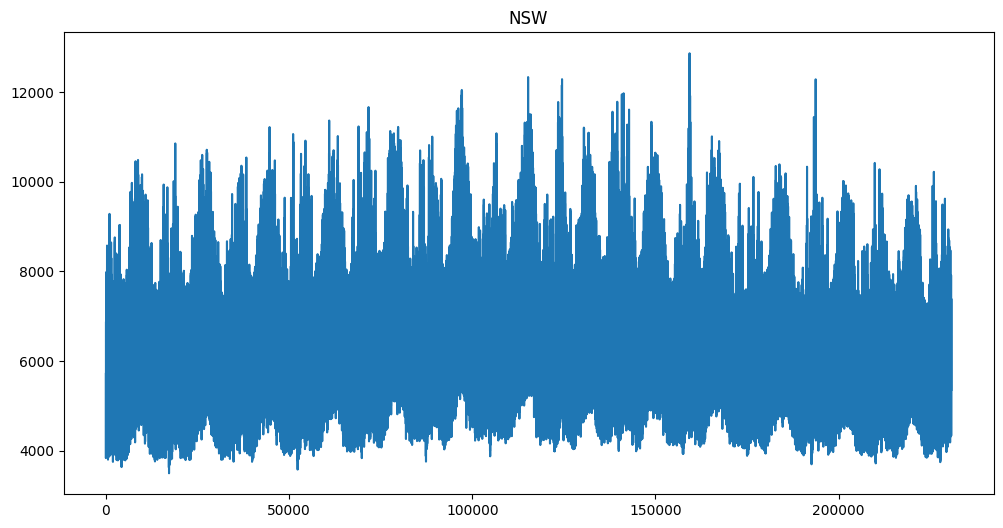

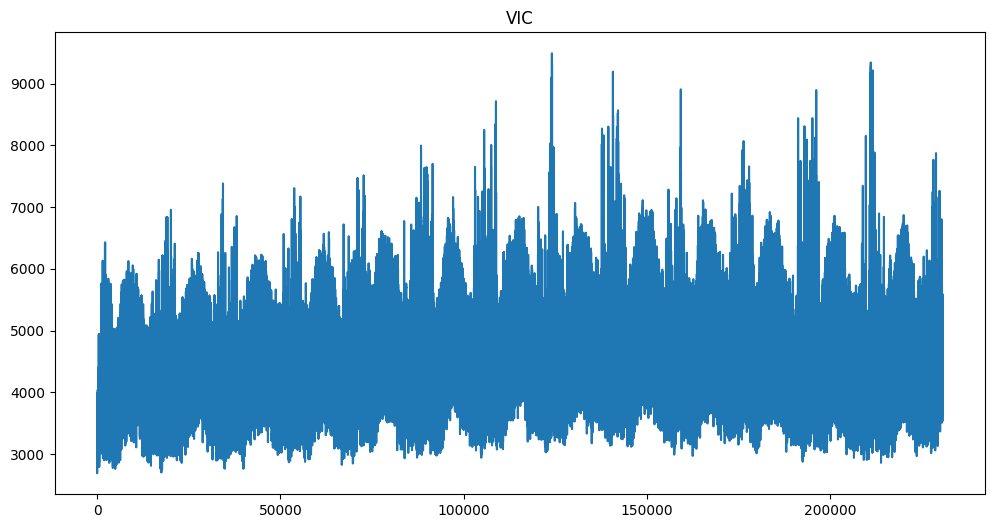

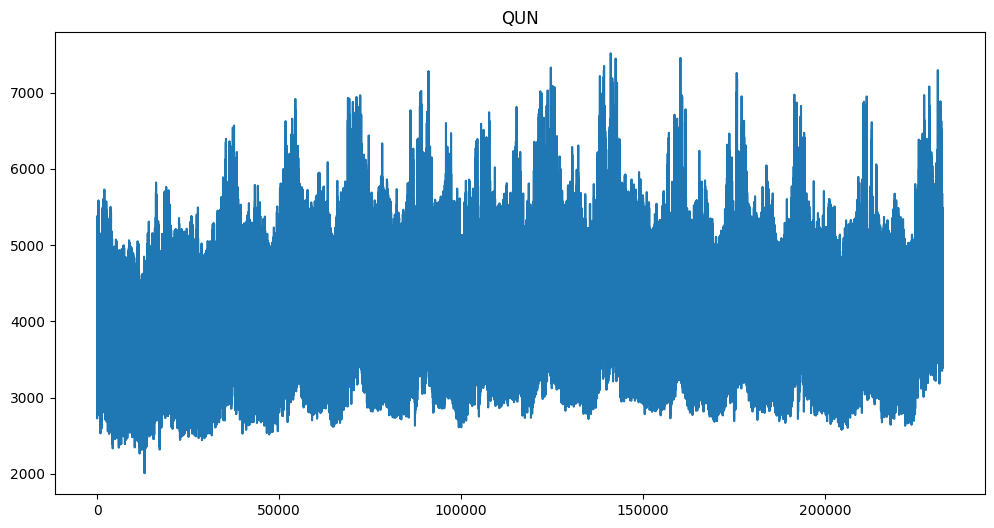

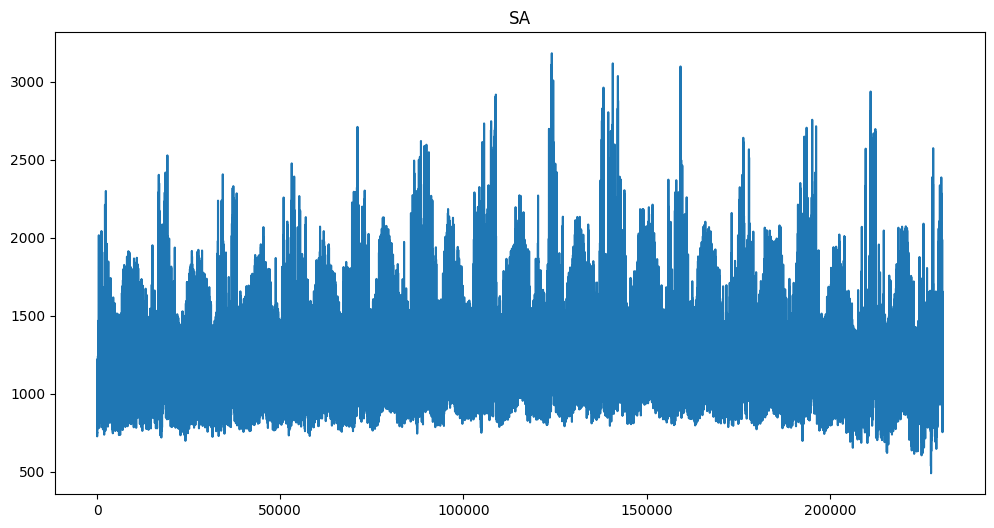

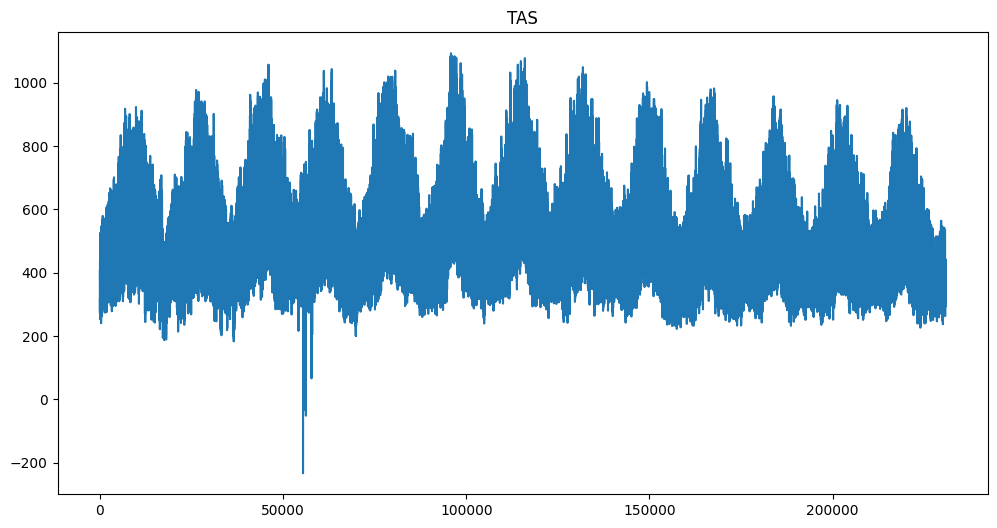

In [8]:
x_distance = round(df["series_length"].max(), -3)

for columns, row in df.iterrows():
    num_steps = len(row["series_value"])
    xtict = np.arange(0, num_steps, )
    fig, ax = plt.subplots(figsize=(12,6))
    plt.title(str(row["state"]))
    ax.plot(np.arange(0,num_steps), row["series_value"])
    


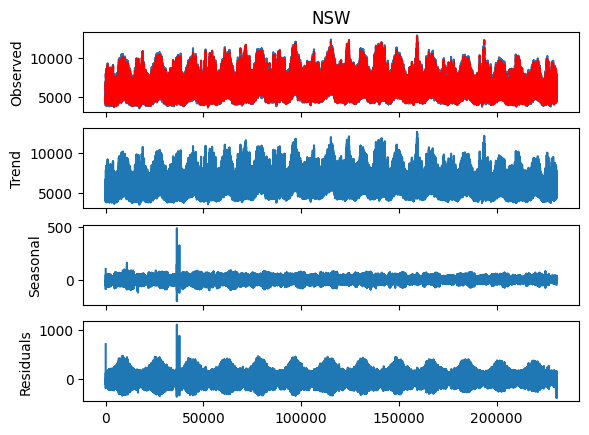

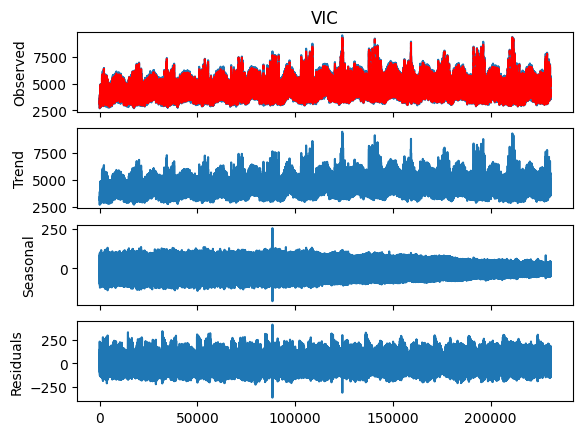

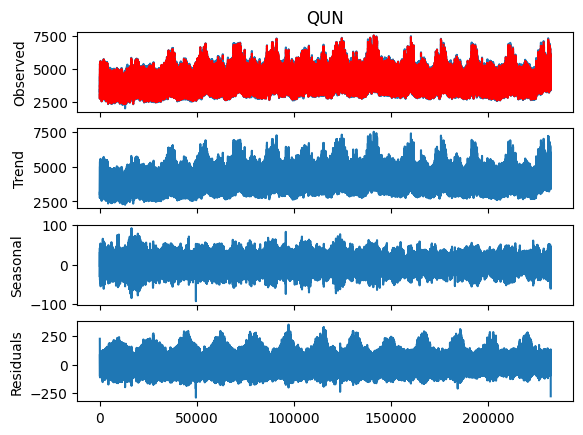

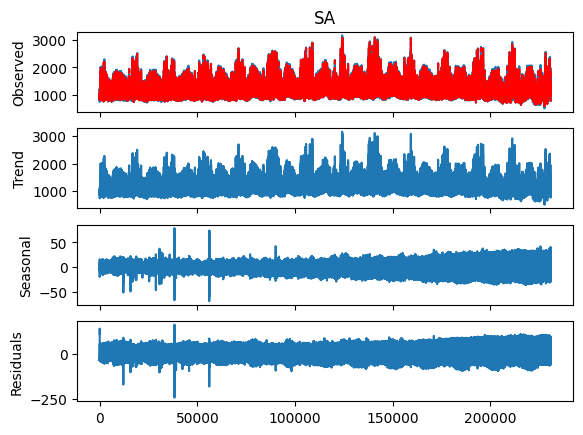

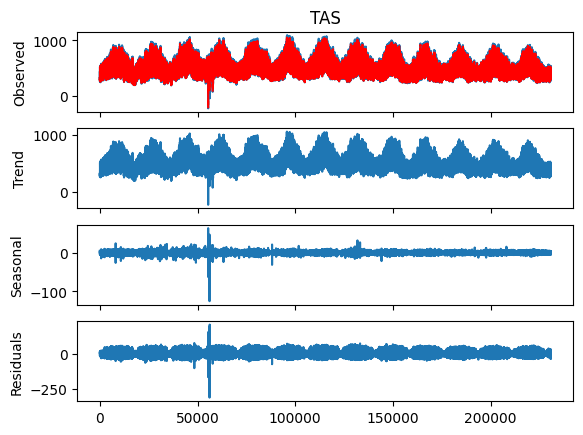

In [9]:
for columns, state in df.iterrows():
    

    advanced_decomposition = STL(state["series_value"], period=4).fit()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

    ax1.set_title(str(state["state"]))
    ax1.plot(advanced_decomposition.observed)
    ax1.plot(advanced_decomposition.trend, color='red', linestyle='--', label='Trend')
    ax1.set_ylabel('Observed')

    ax2.plot(advanced_decomposition.trend)
    ax2.set_ylabel('Trend')

    ax3.plot(advanced_decomposition.seasonal)
    ax3.set_ylabel('Seasonal')

    ax4.plot(advanced_decomposition.resid)
    ax4.set_ylabel('Residuals')
    

In [10]:
df_exploded.head()

,series_name,state,timestamp,data
0,T1,NSW,2002-01-01 00:00:00,5714.045004
1,T1,NSW,2002-01-01 00:30:00,5360.189078
2,T1,NSW,2002-01-01 01:00:00,5014.835118
3,T1,NSW,2002-01-01 01:30:00,4602.755516
4,T1,NSW,2002-01-01 02:00:00,4285.179828


df_daily = df_exploded['timestamp'].dt.day.unique()

for index, row in df_exploded.itterrows():
    


In [11]:
df_exploded['timestamp'].dt.date.unique()

array([datetime.date(2002, 1, 1), datetime.date(2002, 1, 2),
       datetime.date(2002, 1, 3), ..., datetime.date(2015, 3, 30),
       datetime.date(2015, 3, 31), datetime.date(2015, 4, 1)],
      dtype=object)

In [12]:
df_jan2002 = df_exploded['timestamp']

# Get unique states and years
states = df_exploded['state'].unique()
years = df_exploded['timestamp'].dt.year.unique()
years = sorted(years)

print(f"States: {states}")
print(f"Years: {years}")

# Create one figure per state
for state in states:
    # Filter data for current state
    state_data = df_exploded[df_exploded['state'] == state]
    
    # Get years for this state
    state_years = sorted(state_data['timestamp'].dt.year.unique())
    state_month = state_data['timestamp'].dt.month.unique()
    
    # Create single plot for this state
    fig, ax = plt.subplots(figsize=(15, 8))
    fig.suptitle(f'Electricity Demand - {state}', fontsize=16, fontweight='bold')
    
    # Plot each year as a separate line - aligned by months
    for year in state_years:
        year_data = state_data[state_data['timestamp'].dt.year == year]
        
        if not year_data.empty:
            # Create a standardized time index for this year (Jan 1 to Dec 31)
            # Use the first year as reference for the time axis
            if year == state_years[0]:
                # For the first year, use actual dates
                ax.plot(year_data['timestamp'], year_data['data'], 
                       linewidth=0.8, alpha=0.2, label=f'{year}')
            else:
                # For other years, align to the same time axis
                # Create a standardized time range (Jan 1 to Dec 31 of the first year)
                first_year_data = state_data[state_data['timestamp'].dt.year == state_years[0]]
                reference_timestamps = first_year_data['timestamp'].copy()
                
                # Create aligned timestamps for current year
                aligned_timestamps = reference_timestamps.copy()
                aligned_timestamps = aligned_timestamps.map(lambda x: x.replace(year=year))
                
                # Only plot if we have data for the aligned timestamps
                valid_indices = aligned_timestamps.isin(year_data['timestamp'])
                if valid_indices.any():
                    aligned_data = year_data[year_data['timestamp'].isin(aligned_timestamps[valid_indices])]
                    aligned_times = aligned_timestamps[valid_indices]
                    
                    # Sort by timestamp to ensure proper plotting order
                    plot_data = pd.DataFrame({
                        'timestamp': aligned_times,
                        'series_value': aligned_data['data'].values
                    }).sort_values('timestamp')
                    
                    ax.plot(plot_data['timestamp'], plot_data['series_value'], 
                           linewidth=0.8, alpha=0.2, label=f'{year}')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Demand (MW)')
    ax.set_title(f'{state} - All Years Aligned by Month')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)
    
    # Format x-axis to show months
    ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
    
    plt.tight_layout()
    plt.show()

states = df_exploded['state'].unique()
years = df_exploded['timestamp'].dt.year.unique()
years = sorted(years)

print(f"States: {states}")
print(f"Years: {years}")

# Create one figure per state
for state in states:
    # Filter data for current state
    state_data = df_exploded[df_exploded['state'] == state]
    
    # Get years for this state
    state_years = sorted(state_data['timestamp'].dt.year.unique())
    state_month = state_data['timestamp'].dt.month.unique()
    
    # Create single plot for this state
    fig, ax = plt.subplots(figsize=(15, 8))
    fig.suptitle(f'Electricity Demand - {state}', fontsize=16, fontweight='bold')
    
    # Plot each year as a separate line - aligned by months
    for year in state_years:
        year_data = state_data[state_data['timestamp'].dt.year == year]
        
        if not year_data.empty:
            # Create a standardized time index for this year (Jan 1 to Dec 31)
            # Use the first year as reference for the time axis
            if year == state_years[0]:
                # For the first year, use actual dates
                ax.plot(year_data['timestamp'], year_data['data'], 
                       linewidth=0.8, alpha=0.2, label=f'{year}')
            else:
                # For other years, align to the same time axis
                # Create a standardized time range (Jan 1 to Dec 31 of the first year)
                first_year_data = state_data[state_data['timestamp'].dt.year == state_years[0]]
                reference_timestamps = first_year_data['timestamp'].copy()
                
                # Create aligned timestamps for current year
                aligned_timestamps = reference_timestamps.copy()
                aligned_timestamps = aligned_timestamps.map(lambda x: x.replace(year=year))
                
                # Only plot if we have data for the aligned timestamps
                valid_indices = aligned_timestamps.isin(year_data['timestamp'])
                if valid_indices.any():
                    aligned_data = year_data[year_data['timestamp'].isin(aligned_timestamps[valid_indices])]
                    aligned_times = aligned_timestamps[valid_indices]
                    
                    # Sort by timestamp to ensure proper plotting order
                    plot_data = pd.DataFrame({
                        'timestamp': aligned_times,
                        'series_value': aligned_data['series_value'].values
                    }).sort_values('timestamp')
                    
                    ax.plot(plot_data['timestamp'], plot_data['series_value'], 
                           linewidth=0.8, alpha=0.2, label=f'{year}')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Demand (MW)')
    ax.set_title(f'{state} - All Years Aligned by Month')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)
    
    # Format x-axis to show months
    ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
    
    plt.tight_layout()
    plt.show()

## Baseline Statistical Forcating for Energydemand

In [13]:
# Split data for single state
df_t1 = df_exploded[df_exploded['series_name'] == 'T1']
num_datasets = len(df_t1)
print(f"Rows in DF {num_datasets}")
df_t1.head()

Rows in DF 230736


,series_name,state,timestamp,data
0,T1,NSW,2002-01-01 00:00:00,5714.045004
1,T1,NSW,2002-01-01 00:30:00,5360.189078
2,T1,NSW,2002-01-01 01:00:00,5014.835118
3,T1,NSW,2002-01-01 01:30:00,4602.755516
4,T1,NSW,2002-01-01 02:00:00,4285.179828


In [14]:
num_test_datasets = 1440
train = df_t1[:-num_test_datasets]  # Split one month as dataset
test = df_t1[-num_test_datasets:]

historical_mean = np.mean(train['data'])
print(f"Historical mean {historical_mean}")
test.loc[:, 'pred_mean'] = historical_mean
mape_hist_mean = mape(test['data'], test['pred_mean'])
print(f"{mape_hist_mean}")
test


Historical mean 6743.228473474812
18.619194007121212


C:\Users\Joost\AppData\Local\Temp\ipykernel_14372\114823825.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = historical_mean


,series_name,state,timestamp,data,pred_mean
229296,T1,NSW,2015-01-30 00:00:00,5176.136428,6743.228473
229297,T1,NSW,2015-01-30 00:30:00,4960.511356,6743.228473
229298,T1,NSW,2015-01-30 01:00:00,4671.778054,6743.228473
229299,T1,NSW,2015-01-30 01:30:00,4449.348412,6743.228473
229300,T1,NSW,2015-01-30 02:00:00,4287.065374,6743.228473
...,...,...,...,...,...
230731,T1,NSW,2015-02-28 21:30:00,6083.964216,6743.228473
230732,T1,NSW,2015-02-28 22:00:00,5986.856742,6743.228473
230733,T1,NSW,2015-02-28 22:30:00,5749.355504,6743.228473
230734,T1,NSW,2015-02-28 23:00:00,5505.215700,6743.228473


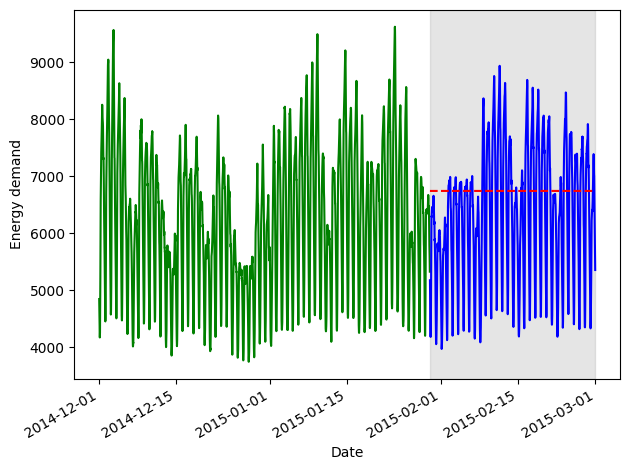

In [41]:
fig, ax = plt.subplots()
end = num_datasets-num_test_datasets
start = num_datasets-num_test_datasets*3
plot_area = np.arange(num_datasets-num_test_datasets*3,num_datasets-num_test_datasets)

ax.plot(train['timestamp'].iloc[np.arange(start, end)], train['data'].iloc[np.arange(start, end)], 'g', label='Train')
ax.plot(test['timestamp'], test['data'], 'b-', label='Test')
ax.plot(test['timestamp'], test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Energy demand')
ax.axvspan(test['timestamp'].iloc[0], test['timestamp'].iloc[-1],  color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

### Baseline Model Last Year

In [20]:
Last_year_mean = np.mean(train['data'][-17520:])
print(f'{Last_year_mean}')
test.loc[:, 'pred_last_yr_mean'] = Last_year_mean
test

6285.899745488128


C:\Users\Joost\AppData\Local\Temp\ipykernel_14372\2148850298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_yr_mean'] = Last_year_mean


,series_name,state,timestamp,data,pred_mean,pred__last_yr_mean,pred_last_yr_mean
229296,T1,NSW,2015-01-30 00:00:00,5176.136428,6743.228473,6285.899745,6285.899745
229297,T1,NSW,2015-01-30 00:30:00,4960.511356,6743.228473,6285.899745,6285.899745
229298,T1,NSW,2015-01-30 01:00:00,4671.778054,6743.228473,6285.899745,6285.899745
229299,T1,NSW,2015-01-30 01:30:00,4449.348412,6743.228473,6285.899745,6285.899745
229300,T1,NSW,2015-01-30 02:00:00,4287.065374,6743.228473,6285.899745,6285.899745
...,...,...,...,...,...,...,...
230731,T1,NSW,2015-02-28 21:30:00,6083.964216,6743.228473,6285.899745,6285.899745
230732,T1,NSW,2015-02-28 22:00:00,5986.856742,6743.228473,6285.899745,6285.899745
230733,T1,NSW,2015-02-28 22:30:00,5749.355504,6743.228473,6285.899745,6285.899745
230734,T1,NSW,2015-02-28 23:00:00,5505.215700,6743.228473,6285.899745,6285.899745


In [21]:
mape_last_year_mean = mape(test['data'], test['pred_last_yr_mean'])
print(mape_hist_mean)
print(mape_last_year_mean)

18.619194007121212
16.946455160993086


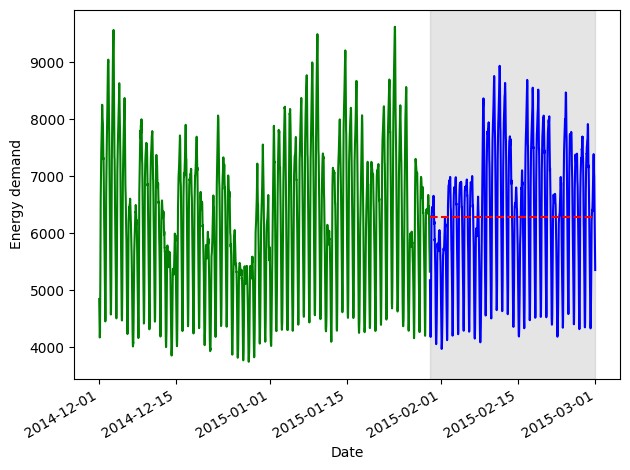

In [40]:
fig, ax = plt.subplots()
end = num_datasets-num_test_datasets
start = num_datasets-num_test_datasets*3
plot_area = np.arange(num_datasets-num_test_datasets*3,num_datasets-num_test_datasets)

ax.plot(train['timestamp'].iloc[np.arange(start, end)], train['data'].iloc[np.arange(start, end)], 'g', label='Train')
ax.plot(test['timestamp'], test['data'], 'b-', label='Test')
ax.plot(test['timestamp'], test['pred_last_yr_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Energy demand')
ax.axvspan(test['timestamp'].iloc[0], test['timestamp'].iloc[-1],  color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

Last: 5326.855176


,series_name,state,timestamp,data,pred_mean,pred__last_yr_mean,pred_last_yr_mean,pred_last,pred_last_season
229296,T1,NSW,2015-01-30 00:00:00,5176.136428,6743.228473,6285.899745,6285.899745,5326.855176,5133.443978
229297,T1,NSW,2015-01-30 00:30:00,4960.511356,6743.228473,6285.899745,6285.899745,5326.855176,4909.163284
229298,T1,NSW,2015-01-30 01:00:00,4671.778054,6743.228473,6285.899745,6285.899745,5326.855176,4612.742286
229299,T1,NSW,2015-01-30 01:30:00,4449.348412,6743.228473,6285.899745,6285.899745,5326.855176,4363.372104
229300,T1,NSW,2015-01-30 02:00:00,4287.065374,6743.228473,6285.899745,6285.899745,5326.855176,4191.695482
...,...,...,...,...,...,...,...,...,...
230731,T1,NSW,2015-02-28 21:30:00,6083.964216,6743.228473,6285.899745,6285.899745,5326.855176,5789.220908
230732,T1,NSW,2015-02-28 22:00:00,5986.856742,6743.228473,6285.899745,6285.899745,5326.855176,5706.435450
230733,T1,NSW,2015-02-28 22:30:00,5749.355504,6743.228473,6285.899745,6285.899745,5326.855176,5595.796592
230734,T1,NSW,2015-02-28 23:00:00,5505.215700,6743.228473,6285.899745,6285.899745,5326.855176,5449.531152


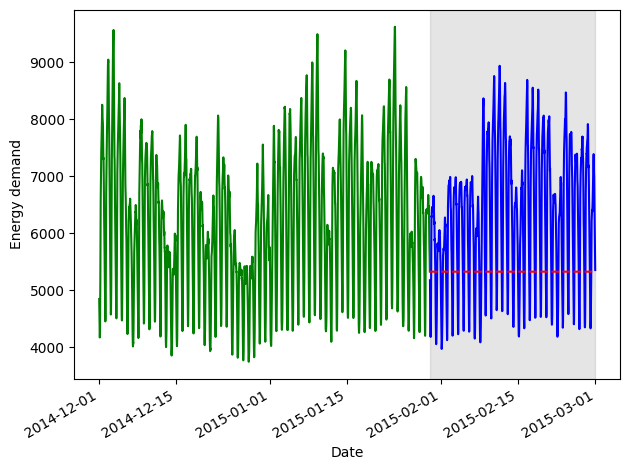

In [48]:
last = train['data'].iloc[-1]
print(f'Last: {last}')
test.loc[:, 'pred_last'] = last
display(test)

fig, ax = plt.subplots()
end = num_datasets-num_test_datasets
start = num_datasets-num_test_datasets*3
plot_area = np.arange(num_datasets-num_test_datasets*3,num_datasets-num_test_datasets)

ax.plot(train['timestamp'].iloc[np.arange(start, end)], train['data'].iloc[np.arange(start, end)], 'g', label='Train')
ax.plot(test['timestamp'], test['data'], 'b-', label='Test')
ax.plot(test['timestamp'], test['pred_last'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Energy demand')
ax.axvspan(test['timestamp'].iloc[0], test['timestamp'].iloc[-1],  color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [25]:
mape_last = mape(test['data'], test['pred_last'])
mape_last

np.float64(19.387169942335884)

,series_name,state,timestamp,data,pred_mean,pred__last_yr_mean,pred_last_yr_mean,pred_last,pred_last_season
229296,T1,NSW,2015-01-30 00:00:00,5176.136428,6743.228473,6285.899745,6285.899745,5326.855176,5133.443978
229297,T1,NSW,2015-01-30 00:30:00,4960.511356,6743.228473,6285.899745,6285.899745,5326.855176,4909.163284
229298,T1,NSW,2015-01-30 01:00:00,4671.778054,6743.228473,6285.899745,6285.899745,5326.855176,4612.742286
229299,T1,NSW,2015-01-30 01:30:00,4449.348412,6743.228473,6285.899745,6285.899745,5326.855176,4363.372104
229300,T1,NSW,2015-01-30 02:00:00,4287.065374,6743.228473,6285.899745,6285.899745,5326.855176,4191.695482
...,...,...,...,...,...,...,...,...,...
230731,T1,NSW,2015-02-28 21:30:00,6083.964216,6743.228473,6285.899745,6285.899745,5326.855176,5789.220908
230732,T1,NSW,2015-02-28 22:00:00,5986.856742,6743.228473,6285.899745,6285.899745,5326.855176,5706.435450
230733,T1,NSW,2015-02-28 22:30:00,5749.355504,6743.228473,6285.899745,6285.899745,5326.855176,5595.796592
230734,T1,NSW,2015-02-28 23:00:00,5505.215700,6743.228473,6285.899745,6285.899745,5326.855176,5449.531152


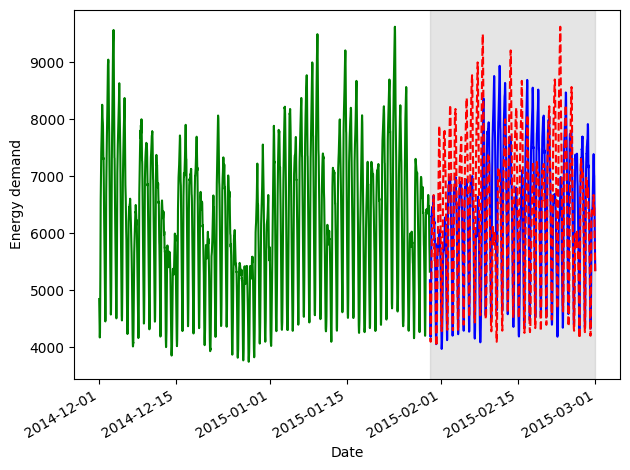

In [49]:
test.loc[:, 'pred_last_season'] = train['data'][-len_test:].values

display(test)

fig, ax = plt.subplots()
end = num_datasets-num_test_datasets
start = num_datasets-num_test_datasets*3
plot_area = np.arange(num_datasets-num_test_datasets*3,num_datasets-num_test_datasets)

ax.plot(train['timestamp'].iloc[np.arange(start, end)], train['data'].iloc[np.arange(start, end)], 'g', label='Train')
ax.plot(test['timestamp'], test['data'], 'b-', label='Test')
ax.plot(test['timestamp'], test['pred_last_season'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Energy demand')
ax.axvspan(test['timestamp'].iloc[0], test['timestamp'].iloc[-1],  color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

mape_naive_seasonal 11.747936722225395


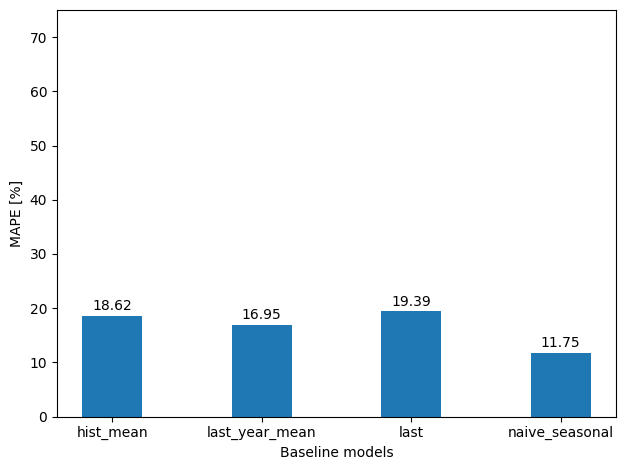

In [51]:
mape_naive_seasonal = mape(test['data'], test['pred_last_season'])
print('mape_naive_seasonal',mape_naive_seasonal)

fig, ax = plt.subplots()

x = ['hist_mean', 'last_year_mean', 'last', 'naive_seasonal']
y = [mape_hist_mean, mape_last_year_mean, mape_last, mape_naive_seasonal]
y = [round(x ,2) for x in y]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Baseline models')
ax.set_ylabel('MAPE [%]')
ax.set_ylim(0, 75)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(value), ha='center')

plt.tight_layout()

## Statistical Methods 
SARIMA (depending on the problem)

## LSTM

## Prophet 

## TimesFM

# 2. Saugeen River Flow (SaugeenDay) (saugeenday_dataset.tsf)
This dataset contains a single very long time series representing the daily mean flow of the Saugeen River at Walkerton in cubic meters per second from 01/01/1915 to 31/12/1979. 
It was extracted from the R deseasonalize package. The length of this time series is 23741.

Download Link on sciebo: https://th-koeln.sciebo.de/s/U6qw87Fq8wKmkCL 

In [ ]:
## Load Data
path = Path("data/exam/saugeenday_dataset.tsf")
saugeenday_df = load_from_tsfile_to_dataframe(path, replace_missing_vals_with="NaN")
saugeenday_df.head()

## Plot Data
saugeenday_df.plot()

## Plot Data
saugeenday_df.plot()


# <font color = Yellow>1. The data sets</font>

All data sets, after unzipping, are either in tsf or in csv format. In the case it is tsf you can use load_tsf_to_dataframe() from sktime. A detailed description can be found here:
https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.datasets.load_tsf_to_dataframe.html 

------------------




## 1.2 Saugeen River Flow (SaugeenDay) (saugeenday_dataset.tsf)
This dataset contains a single very long time series representing the daily mean flow of the Saugeen River at Walkerton in cubic meters per second from 01/01/1915 to 31/12/1979. 
It was extracted from the R deseasonalize package. The length of this time series is 23741.

Download Link on sciebo: https://th-koeln.sciebo.de/s/U6qw87Fq8wKmkCL 

## 1.3 Monthly WTI Oil Price Prediction Dataset (wti_oil_dataset.csv)
A comprehensive dataset for WTI crude oil price prediction, combining key economic indicators and oil industry metrics from 2005-2024. Features include:

* EUR/USD exchange rates, Oil inventory levels, Production volumes, Rig counts, Inflation rates, Technical indicators (rolling averages).

The data was sourced from EIA and FRED APIs, processed and engineered for time series forecasting. Ideal for price prediction models and market analysis.
The data set comes prepared with proper cleaning and feature engineering. It contains economic indicators, which has correlations with wti oil price and technical indicators as 6-12 month wti price rolling means, 6 month wti price lag.
Take the wti price for forecasting

Download Link on sciebo: https://th-koeln.sciebo.de/s/CPzMQGBIdDnpOvd

## 1.4 Egg sales ( :-) ) (egg_sales.zip)
This data set contains detailing 30 years of egg sales from a Sri Lankan shop. You'll uncover the nuances of seasonal fluctuations influenced by cultural festivities, global events, and even unexpected lockdowns. Beyond just raw numbers, this dataset tells a story of traditions, market dynamics and the resilience of businesses. 
Predict the egg sales for 2022.

* Training data (train_egg_sales.csv):
    * Date: The specific day of sales, spanning from 1993 to the end of 2021.
    * Egg Sales: The number of eggs sold on the corresponding date.
* Testing Data (test_egg_sales.csv):
    * Dates for the year 2022 for which you are expected to forecast the egg sales ;-) .

Download Link on sciebo: https://th-koeln.sciebo.de/s/2ydeec9PFc7crzO

## 1.5 Car Parts Dataset (without Missing Values)(car_parts_dataset_without_missing_values.tsf) [OPTIONAL]
This dataset contains 2674 intermittent monthly time series that represent car parts sales from January 1998 to March 2002. It was extracted from R expsmooth package. 
The original dataset contains missing values and they have been replaced by zeros.

Download Link on sciebo: https://th-koeln.sciebo.de/s/xzTVrytuW8DfiPL 

# <font color = Yellow>2. Models</font>
-------------------
## 2.1 TimeGPT from Nixtla
### TEAM: A
TimeGPT was the first foundation model for time series forecasting, characterized by its ability to generalize across diverse domains. It can produce precise forecasts on data sets beyond those used during its training phase. 

## 2.2 N-BEATS and N_HITS (NeuralForecast lib) from Nixtla
### TEAM: B
NeuralForecast is a Python library designed specifically for time series forecasting using advanced deep learning models. It includes models like N-BEATS, N-HITS, and other state-of-the-art techniques, which are well-suited for capturing complex patterns in time series data. NeuralForecast is particularly powerful because it allows for the simultaneous training of multiple models, can handle different data frequencies and is optimized for forecasting multiple time series.

## 2.3 Chronos from Amazon
### TEAM: C
A revolutionary time series model that leverages the intricate mechanics of language processing to predict the future with unprecedented accuracy.

## 2.4 Moirai from Salesforce
### TEAM: D
Moirai is Salesforce’s cutting-edge foundation model for time series forecasting, offering universal forecasting with robust zero-shot predictions across diverse domains, frequencies, and variables and enabling a single versatile model to deliver highly accurate forecasts for any time-series application.

## 2.5 Tiny Time Mixers - TTM from IBM
### TEAM: E
TTM is a lightweight, MLP-based foundation TS model (≤ 1M parameters) that excels in zero-shot forecasting, even outperforming larger SOTA models.

## 2.6 NeuralProphet - Community Project
### TEAM: F
NeuralProphet is a decomposable time series model with the components, trend, seasonality, auto-regression, special events, future regressors and lagged regressors.

# <font color = Yellow>3. Important dates, organization of the exam and task description</font>
---------------

## 3.1 Important Dates
* Preparation:
    * Assign yourself to a team of two to three persons
    * Deadline 18.06.2025 at 5pm
* Assignment of forecasting approach to teams
    * Deadline: 18.06.2025
* Download of data sets for forecasting:
    * Start: 25.06.2025
* Upload of final zip folders containing your notebooks and additional materials
    * Deadline: 09.07.2025 at 3pm in ILU
* Exam session at TH
    * Start: 09.07.2025 at 3pm 
    * Time slots for presentations will be assigned by 25.06.2025
    * Time slots can be found: https://docs.google.com/spreadsheets/d/1BweXjsdQ2dcEUgC-xKkyo0HcTsmrGjp3gDlr8efHJDE/edit?gid=0#gid=0

## <font color = magenta>3.2 Your tasks </font>
* Describe the theory of the forecasting approach assigned to your team (preferably in the notebook you upload). 
* Explain the approach, the most relevant aspects, parameters and features.
    * you can do this in your notebook, or on some extra slides.
    * However, inside the notebook would be preferred.

* Now, for each data set I provided: do forecasts with
    * Baseline(s)
    * statistical methods 
        * SARIMA (depending on the problem)
    * LSTM
    * Prophet 
    * TimesFM
    * The special forecasting method assigned to your team 
    
#### <font color = red>NOTE</font>
* Make sure that you consider different types of forecasts and baselines (obviously depending on the approach) while implementing your forecasting analysis (preferably all in one notebook only) 
* Compare all results from the forecasts from above list and discuss the potential differences thoroughly (some suggestions for leading questions). 
    * i.e. What could be possible explanations for different performances?
    * Is it what you expected?
    * How could the historical data sets deliver reasons for the deviation in precision?
	* What makes you believe this? 
    * Did you carry out some more research or checks to confirm your assumptions?
    * Are there other reasons you could imagine?
    * Last but no least
        * specify your team letter and your names of the team members
        * upload your notebook (or your zip in case you want to upload more) in due time on ILU
        * prepare a presentation as a team for the workshop, where we exchange the results

## <font color = #39FF14>3.3 Time Table for examination day on July 9th</font>

* Start presentations 15.00 (approx. 20 mins each)
    * Team A: 15:00-15:20
    * Team B: 15:25-15:45
        * Break:  15:45-15:55
    * Team C: 15:55-16:15
    * Team D: 16:20-16:40
        * Break:  16:45-16:55
    * Team E: 16:55-17:15
    * Team F: 17:20-17:40 
        * Break:  17:40-17:50
* Plenum: bringing it together and discuss the findings 17:50-18:30 (approx.)

